In [1]:
import torch
import torch.nn as nn
import numpy as np
import os 
from IPython.display import Image
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision 
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from PIL import Image
from torch.utils.data import DataLoader
import os, zipfile, shutil, PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import glob
import xml.etree.ElementTree as xet
from xml.etree import ElementTree
import plotly.express as px
from shutil import copy
import keras
import ultralytics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import pytesseract as pt
from PIL import Image
from xml.etree import ElementTree
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from ultralytics import YOLO

In [3]:
torch.cuda.is_available()

True

In [6]:
model = YOLO("yolov8s.pt") 

In [7]:
data_dir = "C:\\Users\\Piotr\\Desktop\\DANE\\data_images"

In [8]:
xml_files = glob.glob(f"{data_dir}/*.xml")


In [9]:
path = glob.glob('C:\\Users\\Piotr\\Desktop\\DANE\\data_images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [10]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,C:\Users\Piotr\Desktop\DANE\data_images\Cars0.xml,226,419,125,173
1,C:\Users\Piotr\Desktop\DANE\data_images\Cars1.xml,134,262,128,160
2,C:\Users\Piotr\Desktop\DANE\data_images\Cars10...,140,303,5,148
3,C:\Users\Piotr\Desktop\DANE\data_images\Cars10...,175,214,114,131
4,C:\Users\Piotr\Desktop\DANE\data_images\Cars10...,167,240,202,220


In [11]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('C:\\Users\\Piotr\\Desktop\\DANE\\data_images\\',filename_image)
    return filepath_image
getFilename(filename)

'C:\\Users\\Piotr\\Desktop\\DANE\\data_images\\Cars0.png'

In [12]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'C:\\Users\\Piotr\\Desktop\\DANE\\data_images\\/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.tail()

,filepath,xmin,xmax,ymin,ymax,filename,width,height
609,C:\Users\Piotr\Desktop\DANE\data_images\N95.xml,23,408,173,391,C:\Users\Piotr\Desktop\DANE\data_images\/N95.jpeg,450,600
610,C:\Users\Piotr\Desktop\DANE\data_images\N96.xml,137,352,141,186,C:\Users\Piotr\Desktop\DANE\data_images\/N96.jpeg,450,290
611,C:\Users\Piotr\Desktop\DANE\data_images\N97.xml,175,290,228,255,C:\Users\Piotr\Desktop\DANE\data_images\/N97.jpeg,446,282
612,C:\Users\Piotr\Desktop\DANE\data_images\N98.xml,563,675,207,238,C:\Users\Piotr\Desktop\DANE\data_images\/N98.jpeg,704,330
613,C:\Users\Piotr\Desktop\DANE\data_images\N99.xml,158,389,129,193,C:\Users\Piotr\Desktop\DANE\data_images\/N99.jpeg,474,354


In [13]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height,center_x,center_y,bb_width,bb_height
0,C:\Users\Piotr\Desktop\DANE\data_images\Cars0.xml,226,419,125,173,C:\Users\Piotr\Desktop\DANE\data_images\/Cars0...,500,268,0.64500,0.555970,0.3860,0.179104
1,C:\Users\Piotr\Desktop\DANE\data_images\Cars1.xml,134,262,128,160,C:\Users\Piotr\Desktop\DANE\data_images\/Cars1...,400,248,0.49500,0.580645,0.3200,0.129032
2,C:\Users\Piotr\Desktop\DANE\data_images\Cars10...,140,303,5,148,C:\Users\Piotr\Desktop\DANE\data_images\/Cars1...,400,225,0.55375,0.340000,0.4075,0.635556
3,C:\Users\Piotr\Desktop\DANE\data_images\Cars10...,175,214,114,131,C:\Users\Piotr\Desktop\DANE\data_images\/Cars1...,400,267,0.48625,0.458801,0.0975,0.063670
4,C:\Users\Piotr\Desktop\DANE\data_images\Cars10...,167,240,202,220,C:\Users\Piotr\Desktop\DANE\data_images\/Cars1...,400,300,0.50875,0.703333,0.1825,0.060000


In [14]:
df_train = df.iloc[:400]
df_test = df.iloc[400:]

# musisz stworzyć pliki o nazwach train i test w folderze images 

In [15]:
train_folder = 'C:\\Users\\Piotr\\Desktop\\DANE\\data_images\\train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

test_folder = 'C:\\Users\\Piotr\\Desktop\\DANE\\data_images\\test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

In [17]:

device = torch.device("cuda:0")  

model = model.to(device) 

In [18]:
results = model.train(data="C:\\Users\\Piotr\\Desktop\\DANE\\data.yaml", epochs=100) 

engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:\Users\Piotr\Desktop\DANE\data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train24, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=

C:\Users\Piotr\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)



AMP: checks passed 


train: Scanning C:\Users\Piotr\Desktop\DANE\data_images\train... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████|


train: New cache created: C:\Users\Piotr\Desktop\DANE\data_images\train.cache


val: Scanning C:\Users\Piotr\Desktop\DANE\data_images\test... 214 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21

val: New cache created: C:\Users\Piotr\Desktop\DANE\data_images\test.cache


Plotting labels to runs\detect\train24\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train24
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\Piotr\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)

C:\Users\Piotr\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)

      1/100       4.7G      1.656      4.908      1.409         25        640: 100%|██████████| 25/25 [00:08<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.875      0.762      0.845      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.63G      1.482      1.588      1.317         25        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.324      0.771      0.321      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.64G      1.568      1.299      1.347         27        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.781       0.57      0.661      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.61G      1.573      1.359      1.396         30        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214     0.0846      0.262     0.0376     0.0155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.61G      1.647      1.244      1.438         38        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.046       0.14     0.0136    0.00662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.65G      1.557      1.105      1.368         29        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.448      0.246      0.198      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.65G      1.524      1.059       1.35         28        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.674      0.482      0.548      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.65G      1.491      1.043      1.332         29        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.933      0.743      0.845      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.61G      1.466      1.076      1.324         38        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.854      0.845       0.91      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.64G      1.482      1.035      1.359         38        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.899      0.832      0.913      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.65G      1.478      1.022      1.329         28        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.907      0.804       0.88      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.64G      1.463      1.024      1.331         32        640: 100%|██████████| 25/25 [00:08<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.891      0.877       0.93      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.61G      1.484      1.014      1.296         30        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214       0.89      0.879      0.935      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.65G      1.456     0.9931      1.332         19        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.866      0.786      0.884      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.63G      1.422     0.9135      1.298         32        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.879      0.851      0.913      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.64G       1.42     0.9313      1.297         38        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.941      0.888      0.951      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.61G       1.32     0.8691      1.235         24        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.938       0.85      0.956      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.63G      1.436     0.8953      1.281         39        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214       0.91      0.869      0.927      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.64G      1.382      0.849      1.293         34        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.953      0.893      0.966      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.64G      1.333     0.8709       1.25         21        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.937      0.897      0.969      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.61G      1.336     0.8367       1.25         29        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.892      0.921      0.959      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.65G       1.38     0.8574      1.233         38        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.907      0.913      0.949      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.64G      1.315     0.8141      1.239         27        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.933      0.883      0.958      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.65G      1.317     0.8447       1.23         37        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.909      0.897      0.936      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.61G      1.302     0.8402      1.241         25        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.865      0.883      0.935      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.65G      1.322     0.8334       1.24         28        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.951      0.827      0.915       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.63G      1.309     0.7715      1.215         33        640: 100%|██████████| 25/25 [00:08<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.968      0.888      0.967      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.64G      1.255      0.767      1.211         31        640: 100%|██████████| 25/25 [00:08<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.932      0.921      0.969      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.61G      1.235     0.7635      1.216         35        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.956      0.935      0.979      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.64G      1.281     0.7663       1.21         33        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.962      0.893      0.962      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.63G      1.243     0.7472      1.207         36        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214       0.93      0.944      0.977      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.64G      1.238     0.7456      1.213         26        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.939      0.933      0.978      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.61G      1.234     0.7091      1.226         42        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.942      0.935      0.983      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.64G      1.241     0.7535      1.176         23        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.938      0.911      0.967      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.63G      1.199     0.7431      1.191         32        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.977      0.879      0.959      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.64G       1.19     0.7515       1.16         33        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.981      0.846      0.955      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.63G      1.194     0.7224      1.173         32        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214       0.98      0.903      0.977      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.64G      1.202     0.7073      1.168         27        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.949      0.876      0.965      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.65G      1.159     0.7064      1.176         34        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.944      0.879      0.964      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.64G      1.193     0.7134      1.185         28        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.954      0.888      0.966      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.61G      1.214     0.6967      1.207         32        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.933      0.949      0.975      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.65G      1.209     0.6957      1.178         29        640: 100%|██████████| 25/25 [00:08<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.959      0.866      0.965      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.63G       1.18     0.6963      1.173         31        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.962      0.925      0.975        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.64G      1.141     0.6634      1.159         25        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.941      0.921      0.971      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.61G      1.145     0.6741      1.147         29        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.966      0.929      0.978      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.65G      1.126     0.6629      1.128         28        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.961      0.931      0.981      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.63G      1.161     0.6487      1.126         36        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.952      0.931      0.978      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.65G      1.149     0.6445      1.165         29        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.971      0.933      0.962      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.61G      1.088     0.6303      1.131         24        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.937      0.939      0.971      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.64G      1.099     0.6462      1.146         29        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.939      0.928      0.967      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.63G      1.137     0.6193      1.136         35        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.951      0.914      0.969      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.65G      1.136     0.6622      1.161         31        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.942      0.911      0.972      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.61G      1.093     0.6358      1.119         25        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.899      0.918      0.962      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.65G      1.085     0.6186      1.108         38        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.952      0.893      0.963      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.63G      1.108       0.63      1.151         40        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.963      0.911      0.969      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.64G      1.041     0.5927      1.107         33        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.961      0.912      0.985      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.61G      1.048     0.5898       1.09         30        640: 100%|██████████| 25/25 [00:08<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.955      0.916      0.977      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.64G      1.068     0.6264      1.129         27        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.932      0.939      0.977       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.63G      1.075     0.5877      1.123         32        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.953      0.949      0.979       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.64G       1.09     0.6056      1.144         31        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.948      0.939      0.985      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.63G       1.04     0.5903      1.127         32        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214       0.94       0.93      0.972      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.64G      1.044     0.5685      1.102         32        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.938      0.923      0.972      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.65G      1.026     0.5909      1.114         23        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.947       0.93      0.982        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.64G     0.9838      0.542      1.078         28        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214       0.94      0.947      0.986      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.61G     0.9756      0.542      1.072         31        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.891      0.954      0.972       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.65G       1.02     0.5513      1.088         31        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.942      0.939      0.975      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.63G      1.006     0.5687      1.099         27        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.931      0.935      0.968      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.64G     0.9912     0.5536      1.083         24        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.945      0.935      0.976      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.61G          1     0.5487      1.096         29        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214       0.96      0.944      0.985      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.65G     0.9487     0.5341       1.07         35        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.944      0.944      0.981      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.63G     0.9725      0.547      1.094         28        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.934      0.907       0.97      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.65G     0.9782     0.5458      1.073         22        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.941      0.911      0.968      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.61G     0.9589     0.5249      1.073         29        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.926      0.944      0.964      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.64G     0.9873     0.5411      1.083         27        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.931      0.939      0.968      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.63G     0.9285     0.5047       1.06         28        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.955       0.93      0.969      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.65G     0.9108     0.5128      1.052         30        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.935      0.958      0.977      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.61G     0.9385     0.5147      1.073         30        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.919      0.967      0.969      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.65G     0.9178     0.5206      1.044         31        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214       0.94      0.955      0.972      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.63G      0.899      0.505      1.043         38        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.948      0.944      0.979       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.64G     0.9164      0.506      1.041         35        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.946      0.935      0.977      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.61G     0.9253      0.513      1.053         33        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.952      0.953       0.98      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.64G     0.8679     0.4888      1.039         29        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.949       0.95      0.982      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.63G     0.8537     0.4576      1.012         34        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.959       0.93      0.975      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.64G     0.8705     0.4771      1.027         31        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.947      0.935      0.974      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.63G     0.8856     0.4732      1.018         33        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.957      0.933      0.977      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.64G     0.8784     0.4918      1.029         34        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.947      0.939      0.981      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.65G     0.8875     0.4808      1.048         30        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.947       0.93      0.974      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.64G     0.8686     0.4698      1.026         37        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.914      0.963      0.975      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.61G     0.8645     0.4641      1.061         32        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.948      0.939      0.974      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.65G     0.8486      0.481      1.024         33        640: 100%|██████████| 25/25 [00:08<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.947      0.935      0.977      0.629


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.63G     0.8461     0.4387      1.014         16        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.941      0.944      0.972      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.64G     0.8438     0.4409      1.019         16        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.945      0.935      0.968      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.61G     0.8107     0.4176      1.005         16        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.957       0.94      0.977      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.65G     0.8387     0.4222      1.006         16        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.948      0.941      0.977      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.63G     0.7967     0.4121     0.9919         16        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.948      0.938      0.972      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.65G     0.7965     0.4022      1.023         16        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.948       0.93      0.975      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.61G     0.8209      0.416      1.006         16        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.935      0.937      0.976      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.64G     0.7664     0.3947     0.9876         15        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214       0.95      0.935      0.978      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.63G     0.7744      0.407     0.9834         16        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.947      0.935      0.979      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.65G     0.7643     0.4018     0.9883         15        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0

                   all        214        214      0.943      0.935      0.979      0.632



100 epochs completed in 0.292 hours.
Optimizer stripped from runs\detect\train24\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train24\weights\best.pt, 22.5MB

Validating runs\detect\train24\weights\best.pt...
Ultralytics YOLOv8.2.22  Python-3.11.7 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


C:\Users\Piotr\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<0


                   all        214        214      0.957      0.939      0.977      0.638
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\train24


In [67]:
model.export()

Ultralytics YOLOv8.2.22  Python-3.11.7 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)

PyTorch: starting from 'runs\detect\train24\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)

TorchScript: starting export with torch 2.3.0+cu118...
TorchScript: export success  1.3s, saved as 'runs\detect\train24\weights\best.torchscript' (42.9 MB)

Export complete (1.4s)
Results saved to C:\Users\Piotr\PROJEKT\runs\detect\train24\weights
Predict:         yolo predict task=detect model=runs\detect\train24\weights\best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs\detect\train24\weights\best.torchscript imgsz=640 data=C:\Users\Piotr\Desktop\DANE\data.yaml  
Visualize:       https://netron.app


'runs\\detect\\train24\\weights\\best.torchscript'

In [51]:
test_result = model.predict(source='C:\\Users\\Piotr\\Desktop\\DANE\\data_images\\val\*.png',conf = 0.7)


image 1/44 C:\Users\Piotr\Desktop\DANE\data_images\val\Cars174.png: 384x640 (no detections), 75.8ms
image 2/44 C:\Users\Piotr\Desktop\DANE\data_images\val\Cars175.png: 480x640 (no detections), 57.8ms
image 3/44 C:\Users\Piotr\Desktop\DANE\data_images\val\Cars176.png: 416x640 1 license_plate, 50.9ms
image 4/44 C:\Users\Piotr\Desktop\DANE\data_images\val\Cars392.png: 448x640 1 license_plate, 11.0ms
image 5/44 C:\Users\Piotr\Desktop\DANE\data_images\val\Cars393.png: 352x640 1 license_plate, 10.0ms
image 6/44 C:\Users\Piotr\Desktop\DANE\data_images\val\Cars394.png: 480x640 (no detections), 11.0ms
image 7/44 C:\Users\Piotr\Desktop\DANE\data_images\val\Cars395.png: 512x640 1 license_plate, 11.0ms
image 8/44 C:\Users\Piotr\Desktop\DANE\data_images\val\Cars396.png: 640x480 1 license_plate, 9.0ms
image 9/44 C:\Users\Piotr\Desktop\DANE\data_images\val\Cars397.png: 480x640 1 license_plate, 10.0ms
image 10/44 C:\Users\Piotr\Desktop\DANE\data_images\val\Cars398.png: 480x640 1 license_plate, 8.9ms


In [65]:
img1 = test_result[28].plot()
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1 = Image.fromarray(img1)
img1 = img1.resize((400,400))
img2 = test_result[29].plot()
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = Image.fromarray(img2)
img2 = img2.resize((400,400))
img3 = test_result[30].plot()
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img3 = Image.fromarray(img3)
img3 = img3.resize((400,400))
img4 = test_result[31].plot()
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img4 = Image.fromarray(img4)
img4 = img4.resize((400,400))

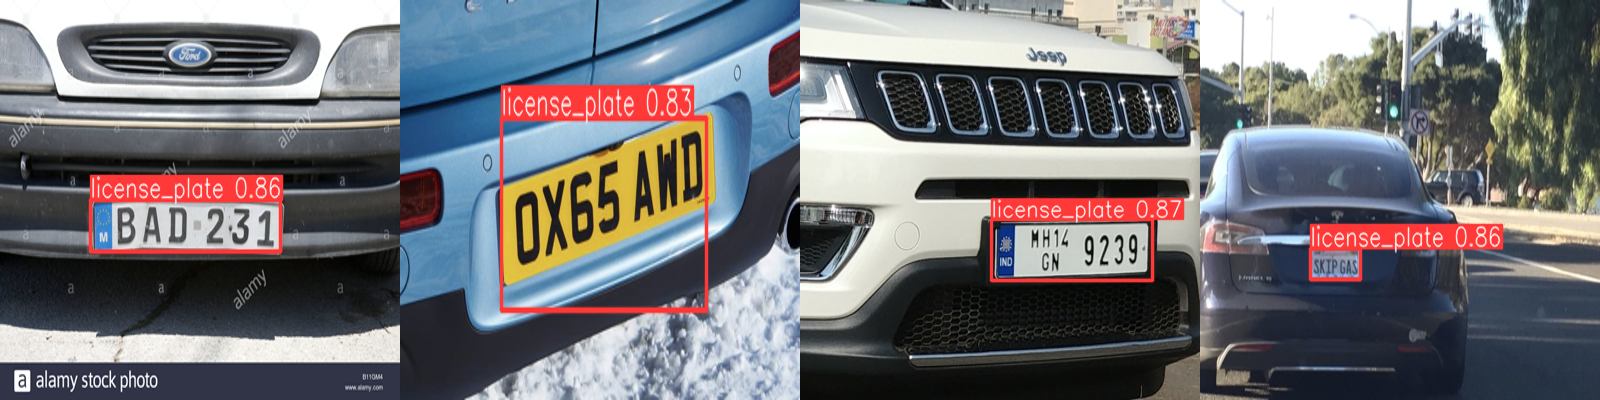

In [66]:
total_width = img1.width + img2.width + img3.width + img4.width
max_height = max(img1.height, img2.height, img3.height,img4.height)
final_image = Image.new('RGB', (total_width, max_height))

# Paste resized images onto the final image
final_image.paste(img1, (0, 0))
final_image.paste(img2, (img1.width, 0))
final_image.paste(img3, (img1.width + img2.width, 0))
final_image.paste(img4, (img1.width + img2.width + img3.width, 0))

# Display the final image
display(final_image)

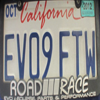

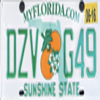

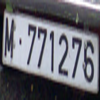

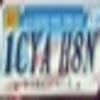

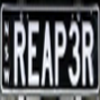

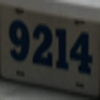

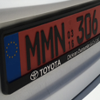

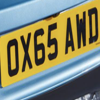

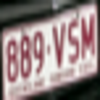

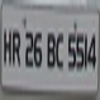

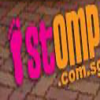

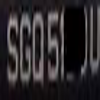

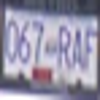

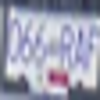

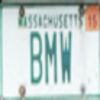

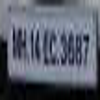

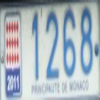

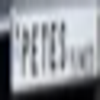

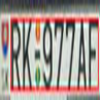

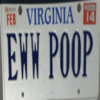

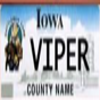

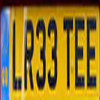

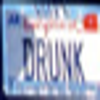

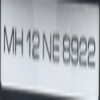

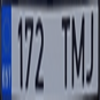

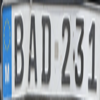

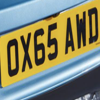

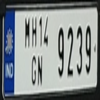

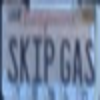

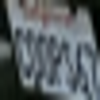

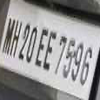

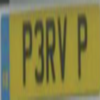

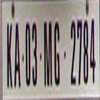

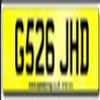

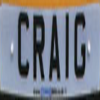

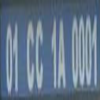

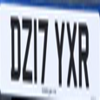

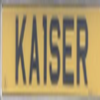

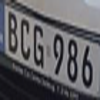

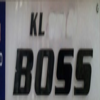

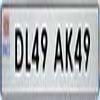

In [78]:
from PIL import Image
import cv2
from IPython.display import display

def get_cropped_boxes(result):
    img = result.orig_img  
    boxes = result.boxes.xyxy  

    cropped_boxes = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        cropped_img = img[y1:y2, x1:x2]  
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        cropped_img = Image.fromarray(cropped_img)
        cropped_img = cropped_img.resize((100, 100))  
        cropped_boxes.append(cropped_img)

    return cropped_boxes


all_cropped_boxes = []
for result in test_result:
    cropped_boxes = get_cropped_boxes(result)
    all_cropped_boxes.extend(cropped_boxes)

for box in all_cropped_boxes[:]:
    display(box)

In [ ]:
from PIL import Image
import cv2
import os


def savecropped_boxes(result, output_dir, result_index):
    img = result.orig_img 
    boxes = result.boxes.xyxy  
    os.makedirs(output_dir, exist_ok=True)

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box[:4])
        cropped_img = img[y1:y2, x1:x2]  
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        cropped_img = Image.fromarray(cropped_img)
        cropped_img = cropped_img.resize((100, 100)) 


        save_path = os.path.join(output_dir, f"cropped_box{resultindex}{i}.jpg")
        cropped_img.save(save_path)


        print(f"Zapisano: {save_path}")


output_directory = "C:\\Users\\Piotr\\Desktop\\TABLICE"

for idx, result in enumerate(test_result):
    save_cropped_boxes(result, output_directory, idx)